# HierMinimax

Expeirments for the non-convex case.

## Installation

In [ ]:
# if you are using Google Colab, all required packages are already installed.
# otherwise, uncomment the following commands (if the pip command does not work, please try to change !pip to !pip3 for all the commands)

# !pip install numpy
# !pip install matplotlib
# !pip install torch
# !pip install tensorflow
# !pip install tensorflow_datasets

# Utilities

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import os
from collections import Counter
import itertools
import time

######################### Results Utilities #################################
project_folder = './'
results_path = os.path.join(project_folder, 'results')
images_path = os.path.join(project_folder, 'images')
os.makedirs(results_path, exist_ok=True)
os.makedirs(images_path, exist_ok=True)

def save_results(result_name, accuracy, loss, accuracy_per_domain, loss_per_domain, result_extension='npy'):
    path = os.path.join(results_path, result_name + "." + result_extension)
    with open(path, 'wb') as f:
        np.save(f, accuracy)
        np.save(f, loss)
        np.save(f, accuracy_per_domain)
        np.save(f, loss_per_domain)

def load_results(result_name, result_extension='npy'):
    path = os.path.join(results_path, result_name + "." + result_extension)
    with open(path, 'rb') as f:
        accuracy = np.load(f)
        loss = np.load(f)
        accuracy_per_domain = np.load(f)
        loss_per_domain = np.load(f)
    return accuracy, loss, accuracy_per_domain, loss_per_domain


######################### Plotting Utilities #################################
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(images_path, fig_id + "." + fig_extension)
    print("Saving figure: ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_metric_over_rounds(results, figure_name, metric='accuracy', save=False):
    xpoints = np.arange(results.shape[0])
    plt.plot(xpoints, results)
    plt.xlabel("communication rounds")
    plt.ylabel(metric)
    plt.grid(True)
    # plt.title(f"{metric} over rounds")
    print(f"{metric} over rounds")
    if save:
        save_fig(figure_name)
    plt.show()

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
def plot_metric_over_rounds_over_tau(results, figure_name, legend, metric='accuracy', detail=False, save=False):
    if not detail:
        xpoints = np.arange(results[0].shape[0])
        num_curves = len(results)
        fmt = ['-o', '-*', '-^', 's-', 'D-']
        fmt = fmt[:num_curves]
        colors = ['#2ca02c', '#ff7f0e', '#1f77b4', '#9467bd','#d62728']
        for i, result in enumerate(results):
            plt.plot(xpoints, result, fmt[i], linewidth=0.6, markersize=4, markevery=3000, color=colors[i])
        plt.xlabel("communication rounds", fontsize="15")
        plt.ylabel(metric, fontsize="15")
        plt.grid(True)
        plt.legend(legend, fontsize="13")
        if save:
            save_fig(figure_name)
        plt.show()
    else:
        fig, ax = plt.subplots(1,1)
        num_curves = len(results)
        fmt = ['-o', '-*', '-^', 's-', 'D-']
        fmt = fmt[:num_curves]
        xpoints = np.arange(results[0].shape[0])
        for i, result in enumerate(results):
            ax.plot(xpoints, result, fmt[i], linewidth=0.6, markersize=4, markevery=500)
        axins = ax.inset_axes((0.5, 0.37, 0.4, 0.3))
        for i, result in enumerate(results):
            axins.plot(xpoints, result, fmt[i], linewidth=0.6, markersize=4, markevery=500)

        # set zoom
        zone_left, zone_right = 950, 1050
        # set ratio
        x_ratio, y_ratio = 0.5, 0.5

        # set range of x
        xlim0 = xpoints[zone_left]-(xpoints[zone_right]-xpoints[zone_left])*x_ratio
        xlim1 = xpoints[zone_right]+(xpoints[zone_right]-xpoints[zone_left])*x_ratio

        # set range of y
        y = np.hstack((results[0][zone_left:zone_right], results[1][zone_left:zone_right], results[2][zone_left:zone_right], results[3][zone_left:zone_right]))
        ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
        ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio

        axins.set_xlim(xlim0, xlim1)
        axins.set_ylim(ylim0, ylim1)

        # loc1 loc2:
        # 1 (topright) 2 (topleft) 3 (bottomleft) 4 (bottomright)
        if  metric == 'accuracy':
            mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec='k', lw=1)
        elif metric == 'worst accuracy':
            mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec='k', lw=1)
        elif metric == 'loss':
            mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec='k', lw=1)

        ax.set_xlabel('communication rounds')
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend(legend)
        if save:
            save_fig(figure_name)
        plt.show()

def plot_metric_over_iterations_over_tau(results, figure_name, legend, tau_list, metric='accuracy', save=False):
    num_curves = len(results)
    fmt = ['-o', '-*', '-^', 's-', 'D-']
    fmt = fmt[:num_curves]
    for i, result in enumerate(results):
        tau = tau_list[i][0] * tau_list[i][1]
        xpoints = np.arange(0, 1+(result.shape[0]-1)*tau, tau)
        plt.plot(xpoints, result, fmt[i], linewidth=0.6, markersize=4, markevery=500)
    plt.xlabel("iterations")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend(legend)
    if save:
        save_fig(figure_name)
    plt.show()


def plot_test_accuracy_per_domain(accuracies_per_domain, dataset_name, figure_name, save):
    if dataset_name == "Fashion-MNIST":
        label_to_description = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover",
                            3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt",
                            7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
    elif dataset_name in ["MNIST", "EMNIST"]:
        label_to_description = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5",
                                6: "6", 7: "7", 8: "8", 9: "9"}
    elif dataset_name == "CIFAR-10":
        label_to_description = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog",
                                6: "frog", 7: "horse", 8: "ship", 9: "truck"}
    plt.bar(np.arange(10), accuracies_per_domain)
    for i in range(10):
        plt.text(i, accuracies_per_domain[i], f"{accuracies_per_domain[i]:.2f}", ha = 'center')
    plt.xticks(np.arange(10), [label_to_description[i] for i in range(10)], rotation=20)
    plt.ylim(0, 1)
    # plt.title("Test accuracy of different labels.")
    if save:
        save_fig(figure_name)
    plt.show()



######################### Model Utilities #################################
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)

     def forward(self, x):
         logits = self.linear(x)
         return logits

def init_weights_LR(model):
    if isinstance(model, torch.nn.Linear):
        torch.nn.init.zeros_(model.weight)
        torch.nn.init.zeros_(model.bias)

class NN(torch.nn.Module):
    def __init__(self, input_dimension, num_classes):
        super().__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(input_dimension, 300),
            torch.nn.ReLU())
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(300, 100),
            torch.nn.ReLU())
        self.fc3 = torch.nn.Sequential(
            torch.nn.Linear(100, num_classes)
            )

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

class LeNet5(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            # torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            # torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(400, 120), # (5x5x16, 120)
            torch.nn.ReLU())
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(120, 84),
            torch.nn.ReLU())
        self.fc3 = torch.nn.Sequential(
            torch.nn.Linear(84, num_classes),
            torch.nn.ReLU())

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=5, stride=1, padding='same'),
            # torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = [2, 2], stride = [2, 2]))
            # torch.nn.LocalResponseNorm())
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding='same'),
            # torch.nn.BatchNorm2d(16),
            # torch.nn.LocalResponseNorm(),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = [2, 2], stride = [2, 2]))
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(8*8*32, 256),
            torch.nn.ReLU())
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(256, 10),
            torch.nn.ReLU())

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

def calculate_weighted_parameters(local_params_list, weights=None):
    """
    weighted average of local model parameters
    result = \sum_{i}^{n} weight[i] * local_parameters[i]
    """
    n = len(local_params_list)
    if weights is None:
        weights = np.array([1.0/n] * n)
    new_global_params = local_params_list[0].copy()

    for key in new_global_params.keys(): # for each layer
        new_global_params[key] = torch.zeros_like(new_global_params[key])
        for i in range(n): # summation of weight * local_parameter
            new_global_params[key] += weights[i]*local_params_list[i][key]
    return new_global_params

def aggregate_model(old_global_params, local_params_list, weights=None):
    """
    weighted average of local model parameters
    result = \modelatt + \frac{1}{m}\sum_{n=1}^N a_{n}^{(t)}(\modelatt_{n, J} - \modelatt)
    """
    n = len(local_params_list)
    if weights is None:
        weights = np.array([1.0/n] * n)
    new_global_params = old_global_params.copy()

    for key in new_global_params.keys(): # for each layer
        temp = torch.zeros_like(new_global_params[key])
        for i in range(n): # summation of weight * (local_params - old_global_params)
            temp += weights[i]*(local_params_list[i][key]-old_global_params[key])
        temp /= np.sum(weights)
        new_global_params[key] += temp
    return new_global_params

def project_to_probability(v, s=1):
    assert s > 0, "Radius s must be strictly positive "
    v = torch.from_numpy(v)
    n, = v.shape
    if v.sum() == s and (v >= 0).all():
        return v
    u =  torch.flip(torch.sort(v)[0],dims=(0,)) # sorted v of decreasing order
    cssv = torch.cumsum(u, dim=0) # cumulative sum of decreasingly sorted v
    # get the number of > 0 components of the optimal solution
    non_zero_vector = torch.nonzero(u * torch.arange(1, n+1) > (cssv - s), as_tuple=False)
    if len(non_zero_vector) == 0:
        rho = 0.0
    else:
        rho = non_zero_vector[-1].squeeze()
    theta = (cssv[rho] - s) / (rho + 1.0) # compute the Lagrange multiplier associated to the simplex constraint
    w = (v - theta).clamp(min=0) # compute the projection by thresholding v using theta
    w = w.numpy()
    return w

def _select_clients_exact_without_replacement(probability_simplex, m):
    '''
    Select exact m clients based on probabilities, where probability_simplex is
    a probability simplex
    '''
    assert np.sum(probability_simplex) > 0.9999999 and np.sum(probability_simplex) < 1.0000001
    N = len(probability_simplex)
    selected_clients = np.random.choice(N, size=m, replace=False, p=probability_simplex)
    return selected_clients

def load_dataset(sys_specs, model_name, dataset_name, seed=0):
    np.random.seed(seed)
    if dataset_name in ["MNIST", "Fashion-MNIST"]:
        if dataset_name == "MNIST":
            (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
        else:
            (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
        X_train = X_train_full / 255. # (60000, 28, 28)
        X_test = X_test / 255. # (10000, 28, 28)
        if model_name in ["LR", "NN"]: # LR or full-connected network
            X_train = X_train.reshape(X_train.shape[0], -1) # (60000, 764)
            X_test = X_test.reshape(X_test.shape[0], -1) # (10000, 764)
        else: # CNN
            X_train = np.expand_dims(X_train, axis=1) # (N, C, H, W) = (60000, 1, 28, 28)
            X_test = np.expand_dims(X_test, axis=1) # (10000, 1, 28, 28)
        y_train = y_train_full # (N,)
    elif dataset_name in ["EMNIST"]:
        (X_train_full, y_train_full), (X_test, y_test) = tfds.as_numpy(
            tfds.load('emnist/digits', split=['train', 'test'], batch_size=-1,as_supervised=True,))
        X_train = X_train_full / 255. # (24000, 28, 28, 1)
        X_test = X_test / 255. # (4000, 28, 28, 1)
        if model_name in ["LR", "NN"]: # LR or full-connected network
            X_train = X_train.reshape(X_train.shape[0], -1) # (24000, 764)
            X_test = X_test.reshape(X_test.shape[0], -1) # (4000, 764)
        else: # CNN
            X_train = np.transpose(X_train, axis=(0,3,1,2)) # (N, C, H, W) = (24000, 1, 28, 28)
            X_test = np.expand_dims(X_test, axis=(0,3,1,2)) # (4000, 1, 28, 28)
        y_train = y_train_full # (N,)
    elif dataset_name in ["CIFAR-10"]:
        (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
        X_train = X_train_full / 255. # (50000, 32, 32, 3)
        X_test = X_test / 255.
        if model_name in ["LR", "NN"]:
            X_train = X_train.reshape(X_train.shape[0], -1) # (50000, 3072)
            X_test = X_test.reshape(X_test.shape[0], -1) # (1000, 3072)
        else: # CNN
            X_train = X_train.transpose(0, 3, 1, 2) # (N, C, H, W) = (50000, 3, 32, 32)
            X_test = X_test.transpose(0, 3, 1, 2)# (10000, 3, 32, 32)
        y_train = y_train_full # (N,)
    else:
        print(f"Dataset {dataset_name} is not available.")
        return

    y_train, y_test = y_train.squeeze(), y_test.squeeze()
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # create per-domain data
    per_domain_training_data = {}
    number_class = sys_specs["C"]
    for i in range(number_class):
        per_domain_training_data[i] = X_train[y_train == i, :]

    # create per-distribution data
    per_distribution_training_data = {}
    similarity = sys_specs["similarity"]
    assert 0 <= similarity <= 100, "The similarity should be between 0 and 100."

    num_training_examples = X_train.shape[0]
    NE = sys_specs["NE"] # each edge area has a unique distribution
    num_iid_training_examples = int(num_training_examples * similarity / 100)
    iid_training_examples = (X_train[:num_iid_training_examples, :], y_train[:num_iid_training_examples])
    non_iid_training_examples = (X_train[num_iid_training_examples:, :], y_train[num_iid_training_examples:])
    for i in range(NE):
        per_distribution_training_data_iid_X = iid_training_examples[0][(num_iid_training_examples // NE) * i:(num_iid_training_examples // NE) * (i+1), :]
        per_distribution_training_data_iid_y = iid_training_examples[1][(num_iid_training_examples // NE) * i:(num_iid_training_examples // NE) * (i+1)]
        per_distribution_training_data_non_iid_X = non_iid_training_examples[0][non_iid_training_examples[1] == i, :]
        per_distribution_training_data_non_iid_y = non_iid_training_examples[1][non_iid_training_examples[1] == i]
        per_distribution_training_data[i] = (np.concatenate((per_distribution_training_data_iid_X, per_distribution_training_data_non_iid_X)), np.concatenate((per_distribution_training_data_iid_y, per_distribution_training_data_non_iid_y)))
        print(f"Data of distribution {i}", per_distribution_training_data[i][0].shape, per_distribution_training_data[i][1].shape)

    test_size = sys_specs["test_size"]
    test_data = (X_test[:test_size], y_test[:test_size])
    return per_distribution_training_data, per_domain_training_data, test_data, sys_specs

def test_all_domains(test_data, model, loss_fn):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    X_test, y_test = test_data
    X_test, y_test = torch.from_numpy(X_test.copy()).type(torch.float).to(device), torch.from_numpy(y_test.copy()).type(torch.int64).to(device)
    model.eval()
    with torch.no_grad():
        pred_t = model(X_test)
        correct_t = (pred_t.argmax(1) == y_test).type(torch.float).sum().item()
        correct_t /= X_test.shape[0]
        loss_t = loss_fn(pred_t, y_test).item()
    return correct_t, loss_t


def test_per_domain(test_data, label, model, loss_fn):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    size = test_data.size(dim=0)
    X, y = test_data, torch.full((size,), label, dtype=torch.int64)
    model.eval()
    test_loss, test_accuracy = 0, 0
    with torch.no_grad():
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        test_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_accuracy /= size
    # label_to_description = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover",
    #                         3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt",
    #                         7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
    # print(f"Test Error on {label_to_description[label]}: Accuracy: {(100*test_accuracy):>0.2f}%, Avg loss: {test_loss:>0.4f}")
    return test_accuracy, test_loss

######################### Methods #################################
def train_HierFedAvg(per_distribution_training_data, per_domain_training_data, test_data, sys_specs, model_name, seed, sample_prob='uniform'):
    """
    HierFedAvg
    """
    K = sys_specs["K"] # number of rounds
    tau_1 = sys_specs["tau_1"]
    tau_2 = sys_specs["tau_2"]
    tau = tau_1 * tau_2
    T = K * tau # number of iterations
    N = sys_specs["N"] # number of clients
    NE = sys_specs["NE"] # number of edges
    N0 = N // NE # number of clients per edge
    m = sys_specs["m2"] # number of sampled edges
    C = sys_specs["C"] # number of classes
    d = sys_specs["d"] # dimension of features
    learning_rate = sys_specs["learning_rate"]
    batch_size = sys_specs["batch_size"]

    print("T:", T, " N:", N)
    ute = np.zeros(shape=(K+1,NE)) # sampled edges with corresponding weights

    accuracy = np.zeros(K+1)
    loss = np.zeros(K+1)
    accuracy_per_domain = np.zeros((K+1, C))
    loss_per_domain = np.zeros((K+1, C))


    np.random.seed(seed)
    torch.manual_seed(seed)
    loss_fn = torch.nn.CrossEntropyLoss()
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # model initialization
    if model_name == "LR":
        global_model = LogisticRegression(d, C)
        global_model.apply(init_weights_LR) # initialize parameters to zeros
        global_model.to(device)

        local_models = [LogisticRegression(d, C) for _ in range(N)]
        for i in range(N):
            local_models[i].apply(init_weights_LR)
            local_models[i].to(device)
    elif model_name == "NN":
        global_model = NN(d, C)
        global_model.to(device)
        dummy_model = NN(d, C)
        dummy_model.to(device)
        dummy_model.load_state_dict(global_model.state_dict().copy())
        local_models = [NN(d, C)  for _ in range(N)]
        for i in range(N):
            local_models[i].to(device)
            local_models[i].load_state_dict(global_model.state_dict().copy())
    elif model_name == "CNN":
        global_model = CNN()
        global_model.to(device)
        dummy_model = CNN()
        dummy_model.to(device)
        dummy_model.load_state_dict(global_model.state_dict().copy())
        local_models = [CNN() for _ in range(N)]
        for i in range(N):
            local_models[i].to(device)
            local_models[i].load_state_dict(global_model.state_dict().copy())
    else:
        print("unknown model")

    # evalute initial model
    accuracy[0] , loss[0] = test_all_domains(test_data, global_model, loss_fn)
    print(f"Before training: overall test accuracy {accuracy[0]:.4f}, test loss {loss[0]:.4f}")
    X_test, y_test = test_data
    for i in range(C):
        per_domain_test_data = torch.from_numpy(X_test[y_test == i, :]).type(torch.float).to(device)
        accuracy_per_domain[0, i], loss_per_domain[0, i] = test_per_domain(per_domain_test_data, i, global_model, loss_fn)


    for k in range(1, K+1):
        # update scheduling indicator: u
        if sample_prob == 'uniform':
            idx = np.random.permutation(NE)[:m]
            ute[k, idx] = 1.0
        elif sample_prob == 'random':
            selected_edges = _select_clients_exact_without_replacement((1.0/NE)*np.ones(NE), m)
            ute[k, selected_edges] = 1.0

        for t2 in range(tau_2):
            for t1 in range(tau_1):
                t = (k-1)*tau+t2*tau_1+t1
                for i in range(N):
                    if ute[k, i//N0] > 0:
                        local_models[i].train()
                        loss_fn = torch.nn.CrossEntropyLoss()
                        optimizer = torch.optim.SGD(local_models[i].parameters(), lr=learning_rate)
                        indices = np.random.randint(per_distribution_training_data[i//N0][0].shape[0], size=batch_size) # select indices of samples
                        X, y = (per_distribution_training_data[i//N0][0][indices, :], per_distribution_training_data[i//N0][1][indices])
                        X, y = torch.from_numpy(X).type(torch.float).to(device), torch.from_numpy(y).type(torch.int64).to(device)

                        # Compute prediction error
                        pred = local_models[i](X)
                        loss_train = loss_fn(pred, y)

                        # Backpropagation
                        optimizer.zero_grad()
                        loss_train.backward()
                        optimizer.step()
                    else:
                        pass # do not update local model
            # local aggregation
            local_params_list = [local_models[i].state_dict().copy() for i in range(N)]
            edge_params_list =  [calculate_weighted_parameters(local_params_list[i*N0:(i+1)*N0]) for i in range(NE)]
            # edge server broadcast
            for i in range(N):
                local_models[i].load_state_dict(edge_params_list[i//N0])
        weights = ute[k, :]
        weights /= np.sum(weights)
        global_params = calculate_weighted_parameters(edge_params_list, weights=weights)
        global_model.load_state_dict(global_params)
        # server broadcast
        for i in range(N):
            local_models[i].load_state_dict(global_params)

        correct_t , loss_t = test_all_domains(test_data, global_model, loss_fn)
        accuracy[k] = correct_t
        loss[k] = loss_t

        X_test, y_test = test_data
        for i in range(C):
            per_domain_test_data = torch.from_numpy(X_test[y_test == i, :]).type(torch.float).to(device)
            accuracy_per_domain[k, i], loss_per_domain[k, i] = test_per_domain(per_domain_test_data, i, global_model, loss_fn)
        worst_accuracy = np.min( accuracy_per_domain[k, :])
        if k % 200 == 0:
            print(f"After round {k}: test accuracy {accuracy[k]:.4f}, loss {loss[k]:.4f}, and worst distribution accuracy {worst_accuracy}.")
    return accuracy, loss, accuracy_per_domain, loss_per_domain

def train_HierMinimax(per_distribution_training_data, per_domain_training_data, test_data, sys_specs, model_name, seed):
    """
    Hierarchical Minimax Optimization
    """
    K = sys_specs["K"] # number of rounds
    tau_1 = sys_specs["tau_1"]
    tau_2 = sys_specs["tau_2"]
    tau = tau_1 * tau_2
    T = K * tau
    N = sys_specs["N"] # number of clients
    NE = sys_specs["NE"] # number of edges
    N0 = N // NE # number of clients per edge
    m = sys_specs["m2"] # number of sampled edges
    C = sys_specs["C"] # number of classes
    d = sys_specs["d"] # dimension of features
    learning_rate = sys_specs["learning_rate"]
    eta_q = sys_specs["eta_q"]
    # regularizer_q = sys_specs["regularizer_q"]
    batch_size = sys_specs["batch_size"]

    labels_te = np.hstack([np.full((T,1), i) for i in range(NE)]) # label for each edge

    ute = np.zeros(shape=(K+1,NE)) # sampled edges for updating w with corresponding weights
    ute_q = np.zeros(shape=(K+1,NE)) # sampled edges for updating q with corresponding weights
    q = np.zeros(shape=(K+1,NE)) # weight vector
    q[0,:] = np.full(NE, 1/NE)

    accuracy = np.zeros(K+1)
    loss = np.zeros(K+1)
    accuracy_per_domain = np.zeros((K+1, NE))
    loss_per_domain = np.zeros((K+1, NE))

    np.random.seed(seed)
    torch.manual_seed(seed)
    loss_fn = torch.nn.CrossEntropyLoss()
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # model initialization
    if model_name == "LR":
        global_model = LogisticRegression(d, C)
        global_model.apply(init_weights_LR) # initialize parameters to zeros
        global_model.to(device)
        dummy_model = LogisticRegression(d, C) # dummy model for updating q
        dummy_model.apply(init_weights_LR)
        dummy_model.to(device)

        local_models = [LogisticRegression(d, C) for _ in range(N)]
        for i in range(N):
            local_models[i].apply(init_weights_LR)
            local_models[i].to(device)
    elif model_name == "NN":
        global_model = NN(d, C)
        global_model.to(device)
        dummy_model = NN(d, C)
        dummy_model.to(device)
        dummy_model.load_state_dict(global_model.state_dict().copy())
        local_models = [NN(d, C)  for _ in range(N)]
        for i in range(N):
            local_models[i].to(device)
            local_models[i].load_state_dict(global_model.state_dict().copy())
    elif model_name == "CNN":
        global_model = CNN()
        global_model.to(device)
        dummy_model = CNN()
        dummy_model.to(device)
        dummy_model.load_state_dict(global_model.state_dict().copy())
        local_models = [CNN() for _ in range(N)]
        for i in range(N):
            local_models[i].to(device)
            local_models[i].load_state_dict(global_model.state_dict().copy())
    else:
        print("unknown model")

    # evalute initial model
    accuracy[0] , loss[0] = test_all_domains(test_data, global_model, loss_fn)
    print(f"Before training: overall test accuracy {accuracy[0]:.4f}, test loss {loss[0]:.4f}")
    X_test, y_test = test_data
    for i in range(C):
        per_domain_test_data = torch.from_numpy(X_test[y_test == i, :]).type(torch.float).to(device)
        accuracy_per_domain[0, i], loss_per_domain[0, i] = test_per_domain(per_domain_test_data, i, global_model, loss_fn)

    for k in range(1, K+1):
        # update scheduling indicator: u
        selected_edges = _select_clients_exact_without_replacement(q[k-1,:], m)
        ute[k, selected_edges] = 1.0
        tau_1_prime = np.random.randint(0, tau_1) # uniform integer in [0, tau_1)
        tau_2_prime = np.random.randint(0, tau_2) # uniform integer in [0, tau_2)
        local_params_list_prime = [local_models[i].state_dict().copy() for i in range(N)] # placeholder

        # local updates
        for t2 in range(tau_2):
            for t1 in range(tau_1):
                t = (k-1)*tau+t2*tau_1+t1
                for i in range(N):
                    if ute[k, i//N0] > 0:
                        local_models[i].train()
                        loss_fn = torch.nn.CrossEntropyLoss()
                        optimizer = torch.optim.SGD(local_models[i].parameters(), lr=learning_rate)
                        indices = np.random.randint(per_distribution_training_data[i//N0][0].shape[0], size=batch_size) # select indices of samples
                        X, y = (per_distribution_training_data[i//N0][0][indices, :], per_distribution_training_data[i//N0][1][indices])
                        X, y = torch.from_numpy(X).type(torch.float).to(device), torch.from_numpy(y).type(torch.int64).to(device)

                        # Compute prediction error
                        pred = local_models[i](X)
                        loss_train = loss_fn(pred, y)

                        # Backpropagation
                        optimizer.zero_grad()
                        loss_train.backward()
                        optimizer.step()
                        if t1 == tau_1_prime and t2 == tau_2_prime:
                            local_params_list_prime[i] = local_models[i].state_dict().copy()
                    else:
                        pass # do not update local model
            # local aggregation
            local_params_list = [local_models[i].state_dict().copy() for i in range(N)]
            edge_params_list =  [calculate_weighted_parameters(local_params_list[i*N0:(i+1)*N0]) for i in range(NE)]
            for i in range(N):
                local_models[i].load_state_dict(edge_params_list[i//N0])

        weights = ute[k, :]
        weights /= np.sum(weights)
        global_params = calculate_weighted_parameters(edge_params_list, weights=weights)
        global_model.load_state_dict(global_params)
        # server broadcast
        for i in range(N):
            local_models[i].load_state_dict(global_params)

        # server aggregation to update q
        edge_params_list_prime =  [calculate_weighted_parameters(local_params_list_prime[i*N0:(i+1)*N0]) for i in range(NE)]
        global_params_prime = calculate_weighted_parameters(edge_params_list_prime, weights=weights)
        dummy_model.load_state_dict(global_params_prime)
        idx = np.random.permutation(NE)[:m]
        ute_q[k, idx] = 1.0
        v = np.zeros(N)
        for i in range(N):
            if ute_q[k,i//N0] > 0: # sampled
                with torch.no_grad():
                    indices = np.random.randint(per_distribution_training_data[i//N0][0].shape[0], size=batch_size) # select indices of samples
                    X, y = (per_distribution_training_data[i//N0][0][indices, :], per_distribution_training_data[i//N0][1][indices])
                    X, y = torch.from_numpy(X).type(torch.float).to(device), torch.from_numpy(y).type(torch.int64).to(device)
                    pred = local_models[i](X)
                    v[i] = loss_fn(pred, y).item()
        v = np.average(v.reshape(-1, N0), axis=1)
        q_temp = q[k-1, :]+(NE*tau*eta_q/m)*v
        # uniform_vector = np.ones(NE) / NE
        # q_temp = q[k-1, :]+(NE*tau*eta_q/m)*v -2 * regularizer_q * NE * (q[k-1, :]-uniform_vector) # plus regularizer
        q[k, :] = project_to_probability(q_temp)


        # evaluate over all test data
        correct_t , loss_t = test_all_domains(test_data, global_model, loss_fn)
        accuracy[k] = correct_t
        loss[k] = loss_t

        X_test, y_test = test_data
        for i in range(C):
            per_domain_test_data = torch.from_numpy(X_test[y_test == i, :]).type(torch.float).to(device)
            accuracy_per_domain[k, i], loss_per_domain[k, i] = test_per_domain(per_domain_test_data, i, global_model, loss_fn)
        worst_accuracy = np.min( accuracy_per_domain[k, :])
        if k % 200 == 0:
            print(f"After round {k}: accuracy {accuracy[k]:.4f}, loss {loss[k]:.4f}, and worst distribution accuracy {worst_accuracy}.")
            print("q", q[k, :])
    return accuracy, loss, accuracy_per_domain, loss_per_domain


def run_experiments(method, model_name, dataset_name, sys_specs):
    if dataset_name == "Fashion-MNIST":
        label_to_description = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover",
                                3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt",
                                7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
    elif dataset_name == "CIFAR-10":
        label_to_description = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog",
                                6: "frog", 7: "horse", 8: "ship", 9: "truck"}
    else:
        label_to_description = {}
        for i in range(sys_specs["C"]):
            label_to_description[i] = str(i)
    seed = 0
    per_distribution_training_data, per_domain_training_data, test_data, sys_specs = load_dataset(sys_specs, model_name, dataset_name, seed)

    if method == "HierFedAvg":
        accuracy, loss, accuracy_per_domain, loss_per_domain = train_HierFedAvg(per_distribution_training_data, per_domain_training_data, test_data, sys_specs, model_name, seed, sample_prob='uniform')
    elif method == "HierRandom":
        accuracy, loss, accuracy_per_domain, loss_per_domain = train_HierFedAvg(per_distribution_training_data, per_domain_training_data, test_data, sys_specs, model_name, seed, sample_prob='random')
    elif method == "HierMinimax":
        accuracy, loss, accuracy_per_domain, loss_per_domain = train_HierMinimax(per_distribution_training_data, per_domain_training_data, test_data, sys_specs, model_name, seed)
    else:
        print(f"Method {method} is not defined")
    return accuracy, loss, accuracy_per_domain, loss_per_domain

##

In [ ]:
# HierFedAvg, HierMinimax
sys_specs = {
    "batch_size": 8,
    "learning_rate": 1e-3,
    "eta_q": 1e-4,
    "C": 10, # number of classes
    "N": 30, # number of clients #####
    "NE": 10, # number of edges #####
    "m2": 2, # number of sampled edges #####
    "K": 50000, # number of rounds
    "tau_1": 1, # number of local SGD iterations
    "tau_2": 1, # number of local aggregation
    "d": 784, # dimension
    "test_size": 1000,
    "similarity": 50, # s% i.i.d. data and the remaining (100 − s)% by sorting according to label
}

model_names = ["NN"]
dataset_names = ["Fashion-MNIST"]
methods = ["HierFedAvg", "HierMinimax"]

for tau_1 in [1, 2]:
    for tau_2 in [1, 2]:
        sys_specs['tau_1'] = tau_1
        sys_specs['tau_2'] = tau_2
        for dataset_name in dataset_names:
            for model_name in model_names:
                for method in methods:
                    result_name = f"{dataset_name}-{model_name}-{method}-similarity{sys_specs['similarity']}-N{sys_specs['N']}-NE{sys_specs['NE']}-m{sys_specs['m2']}"+\
                    f"-K{sys_specs['K']}-tau{sys_specs['tau_1']}-{sys_specs['tau_2']}-batch{sys_specs['batch_size']}-stepsize{sys_specs['learning_rate']}" + (f"-{sys_specs['eta_q']}" if method == "HierMinimax" else "")
                    # f"-K{sys_specs['K']}-tau{sys_specs['tau_1']}-{sys_specs['tau_2']}-batch{sys_specs['batch_size']}-stepsize{sys_specs['learning_rate']}" + (f"-{sys_specs['eta_q']}-{sys_specs['regularizer_q']}" if method == "HierMinimax" else "")

                    print(result_name)
                    accuracy, loss, accuracy_per_domain, loss_per_domain = run_experiments(method, model_name, dataset_name, sys_specs)
                    save_results(result_name, accuracy, loss, accuracy_per_domain, loss_per_domain)
                    plot_metric_over_rounds(accuracy, result_name + "accuracy", "accuracy")
                    plot_metric_over_rounds(loss, result_name + "loss", "loss")
                    worst_accuracies = np.min(accuracy_per_domain, axis=1)
                    for i in range(1, worst_accuracies.size):
                        worst_accuracies[i] = (worst_accuracies[i-1]*(i-1) + worst_accuracies[i])/i
                    plot_metric_over_rounds(worst_accuracies, result_name + "worst-accuracy", "worst-accuracy")
                    plot_test_accuracy_per_domain(accuracy_per_domain[-1, :], dataset_name, result_name + "final-accuracy", False)


Fashion-MNIST-NN-HierFedAvg-similarity50-N30-NE10-m2-K50000-tau1-1-batch8-stepsize0.001
4422102/4422102 [==============================] - 1s 0us/step
(60000, 784) (60000,) (10000, 784) (10000,)
Data of distribution 0 (6055, 784) (6055,)
Data of distribution 1 (5985, 784) (5985,)
Data of distribution 2 (6011, 784) (6011,)
Data of distribution 3 (5983, 784) (5983,)
Data of distribution 4 (6040, 784) (6040,)
Data of distribution 5 (5970, 784) (5970,)
Data of distribution 6 (5919, 784) (5919,)
Data of distribution 7 (5979, 784) (5979,)
Data of distribution 8 (6028, 784) (6028,)
Data of distribution 9 (6030, 784) (6030,)
T: 50000  N: 30
Before training: overall test accuracy 0.1400, test loss 2.3060


HierMinimax, 0.7555, 0.5174
HierFedAvg, 0.7968, 0.4809
HierMinimax, 0.7951, 0.5748
HierFedAvg, 0.8223, 0.5326
HierMinimax, 0.8162, 0.5816
Fashion-MNIST-NN-similarity50-comparison-N30-NE10-m2-K50000-batch8-stepsize0.001


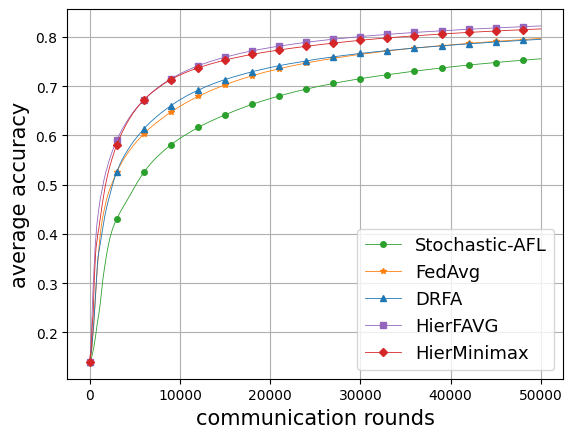

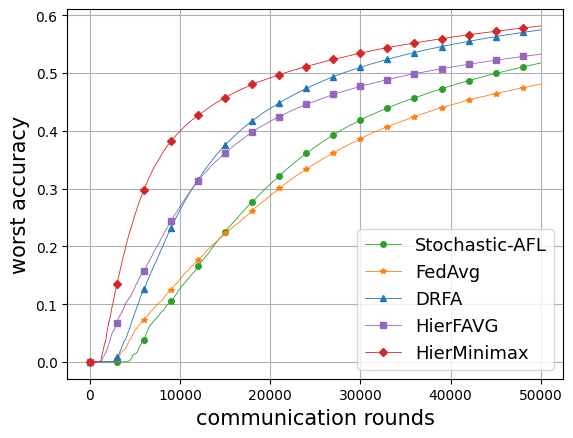

Stochastic-AFL 45201
DRFA 28087
HierFAVG 36445
HierMinimax 21576


In [ ]:
# Plotting, comparison between minimization and minimax
sys_specs = {
    "batch_size": 8,
    "learning_rate": 1e-3,
    "eta_q": 1e-4,
    "C": 10, # number of classes
    "N": 30, # number of clients
    "NE": 10, # number of edges
    "m2": 2, # number of sampled edges
    "K": 50000, # number of rounds
    "tau_1": 1, # number of local SGD iterations
    "tau_2": 1, # number of local aggregation
    "d": 784, # dimension
    "similarity": 50, # s% i.i.d. data and the remaining (100 − s)% by sorting according to label
    "test_size": 1000
}

model_names = ["NN"]
dataset_names = ["Fashion-MNIST"]

# exponential moving average
def smooth(scalars, weight: float):
    if not isinstance(scalars, np.ndarray):
        scalars = np.array(scalars)
    assert scalars.ndim == 1
    assert weight >= 0 and weight <= 1
    num_scalars = scalars.size
    prev = scalars[0]
    smoothed = np.zeros(num_scalars)
    for idx in range(num_scalars):
        smoothed_val = prev * weight + (1 - weight) * scalars[idx]
        smoothed[idx] = smoothed_val
        prev = smoothed_val
    return smoothed

def calculate_time_average(metrics):
    duration = metrics.size
    for i in range(1, duration):
        metrics[i] = (metrics[i-1]*(i-1) + metrics[i])/i
    return metrics

methods = ["HierFedAvg", "HierMinimax"]


accuracy_list = []
loss_list = []
worst_accuracy_list = []
per_domain_accuracy_list = []
tau_list = [(1,1), (2,1),(2,2)]
for tau in tau_list:
    for dataset_name in dataset_names:
        for model_name in model_names:
            for method in methods:
                if tau in [(1,1)] and method in ["HierFedAvg"]: continue
                result_name = f"{dataset_name}-{model_name}-{method}-similarity{sys_specs['similarity']}-N{sys_specs['N']}-NE{sys_specs['NE']}-m{sys_specs['m2']}"+\
                f"-K{sys_specs['K']}-tau{tau[0]}-{tau[1]}-batch{sys_specs['batch_size']}-stepsize{sys_specs['learning_rate']}" + (f"-{sys_specs['eta_q']}" if method == "HierMinimax" else "")
                # result_name = f"{dataset_name}-{model_name}-{method}-similarity{sys_specs['similarity']}-N{sys_specs['N']}-NE{sys_specs['NE']}-m{sys_specs['m2']}"+\
                # f"-K{sys_specs['K']}-tau{sys_specs['tau_1']}-{sys_specs['tau_2']}-batch{sys_specs['batch_size']}-stepsize{sys_specs['learning_rate']}" + (f"-{sys_specs['eta_q']}-{sys_specs['regularizer_q']}" if method == "HierMinimax" else "")

                accuracy, loss, accuracy_per_domain, loss_per_domain = load_results(result_name)
                worst_accuracies = np.min(accuracy_per_domain, axis=1)
                accuracy, loss, worst_accuracies = calculate_time_average(accuracy), calculate_time_average(loss), calculate_time_average(worst_accuracies) # smoothing
                # accuracy, loss, worst_accuracies = accuracy[:20000], loss[:20000], worst_accuracies[:20000]
                accuracy_per_domain = np.concatenate([calculate_time_average(np.expand_dims(accuracy_per_domain[:,i], axis=1)) for i in range(accuracy_per_domain.shape[1])], axis=1)
                per_domain_accuracy_list.append(accuracy_per_domain)
                worst_accuracy_list.append(worst_accuracies)
                accuracy_list.append(accuracy)
                print(f"{method}, {accuracy[-1]:.4f}, {worst_accuracies[-1]:.4f}")



legend = ["Stochastic-AFL", "FedAvg", "DRFA", "HierFAVG", "HierMinimax"]


plot_text = f"{dataset_name}-{model_name}-similarity{sys_specs['similarity']}-comparison-N{sys_specs['N']}-NE{sys_specs['NE']}-m{sys_specs['m2']}"+\
                f"-K{sys_specs['K']}-batch{sys_specs['batch_size']}-stepsize{sys_specs['learning_rate']}"
print(plot_text)
plot_metric_over_rounds_over_tau(accuracy_list, plot_text+"-accuracy", legend, "average accuracy", detail=False, save=True)
plot_metric_over_rounds_over_tau(worst_accuracy_list, plot_text+"-worstaccuracy", legend, "worst accuracy", detail=False, save=True)

for i, algo in enumerate(legend):
    worst_accuracy = worst_accuracy_list[i]
    for j, value in enumerate(worst_accuracy):
        if value > 0.5:
            print(algo, j)
            break